Цель: В этом задании вам предстоит поработать с методом tf-idf чтобы извлечь признаки из текста для построения моделей.
1. Скачайте данные по отзывам с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный".

2. Разбейте данные на train/test, отложив 30% наблюдений для тестирования (датасет достаточно большой и выборка сбалансированная, так что можно не беспокоиться о стратификации)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./data/IMDB Dataset.csv')
print(data.shape)
data.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
target = 'sentiment'

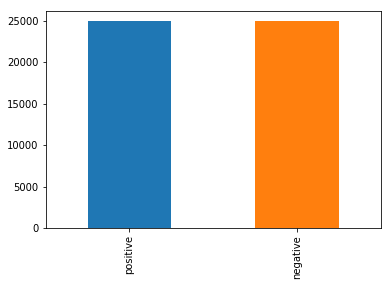

In [4]:
data[target].value_counts().plot.bar()

In [5]:
def get_sentiment(line):
    if line == 'positive':
        return 1
    else:
        return 0
data[target] = data[target].apply(get_sentiment)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [6]:
def remove_tags(line):
    return re.sub('<[^>]*>','', line)
data['review'] = data['review'].apply(remove_tags)

In [7]:
def remove_punctuation(line):
    return re.sub(r'[^\w\s]','', line)
data['review'] = data['review'].apply(remove_punctuation)

In [8]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

stop = stopwords.words('english')
stemmer = SnowballStemmer("english")

def stemmize(text):
    return ' '.join([stemmer.stem(word) for word in text.lower().split() if word not in stop])

Стемминг не сыграл значительную роль для улушения качество модели. Поэтому пойду без него

In [9]:
#data['review'] = data['review'].apply(stemmize)

In [10]:
data.loc[1,'review']

'A wonderful little production The filming technique is very unassuming very oldtimeBBC fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece The actors are extremely well chosen Michael Sheen not only has got all the polari but he has all the voices down pat too You can truly see the seamless editing guided by the references to Williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece A masterful production about one of the great masters of comedy and his life The realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears It plays on our knowledge and our senses particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwells murals decorating every surface are terribly well done'

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.review, data[target], test_size=0.3, stratify=data[target])

3. Примените tf-idf преобразование. Используйте как отдельные токены, так и биграммы, отсейте английские стоп-слова, а также слова, которые встречаются реже, чем в двух отзывах, или чаще, чем в 50% отзывов (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена

4. Постройте логистическую регрессию с настройкой параметра регуляризации, оцените качество при помощи метрик для бинарной классификации

5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Какие слова наиболее характерны для отрицательных отзывов? Какие для положительных?

Критерии оценки: Предобработка текста в tf-idf - 6 баллов
Логит регрессия с оценкой качества - 2 балла
Визуализация коэффициентов - 2 балла

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=2, max_df = 0.5, norm=None)

In [13]:
X_train = tf_vectorizer.fit_transform(X_train)
X_test = tf_vectorizer.transform(X_test)
X_train.shape, X_test.shape

((35000, 471072), (15000, 471072))

#### ML

In [14]:
from sklearn.linear_model import SGDClassifier

logit_sgd = SGDClassifier(loss='log', penalty='l2', random_state=42, class_weight="balanced", n_iter=100, n_jobs=-1)
logit_sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=100,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [15]:
from sklearn.metrics import classification_report

y_pred = logit_sgd.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.90      0.88      0.89      7500
          1       0.89      0.90      0.90      7500

avg / total       0.89      0.89      0.89     15000



### Cofficients visualization

In [16]:
features = tf_vectorizer.get_feature_names()
coefs = logit_sgd.coef_[0]
feature_importances = pd.DataFrame(
    {'feature': features,
    'importances': coefs}
)

In [17]:
feature_importances.set_index('feature', inplace=True)
feature_importances.sort_values('importances', ascending=False, inplace=True)

Top 50 features for Positive review:


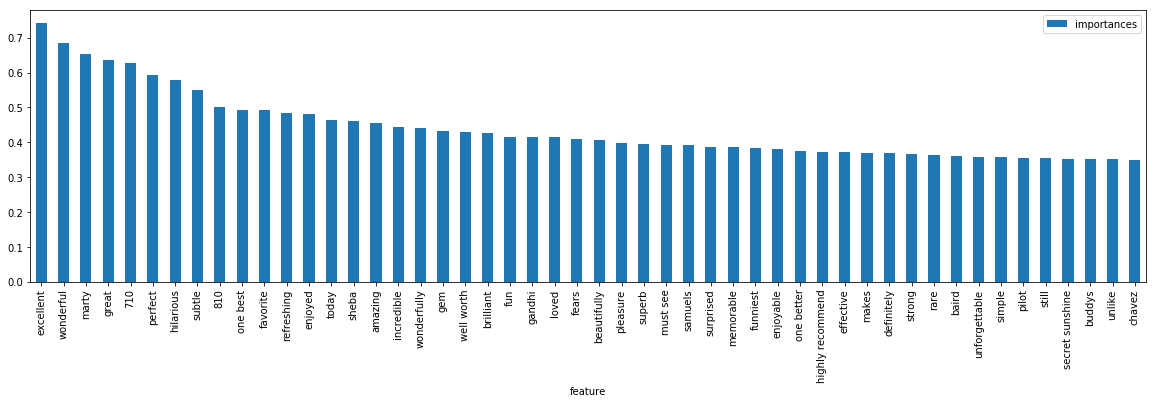

In [18]:
print('Top 50 features for Positive review:')
feature_importances.iloc[:50, :50].plot.bar(figsize=(20,5));

! 710 и 810 неинтерпретируемые

Top 50 features for Negative review:


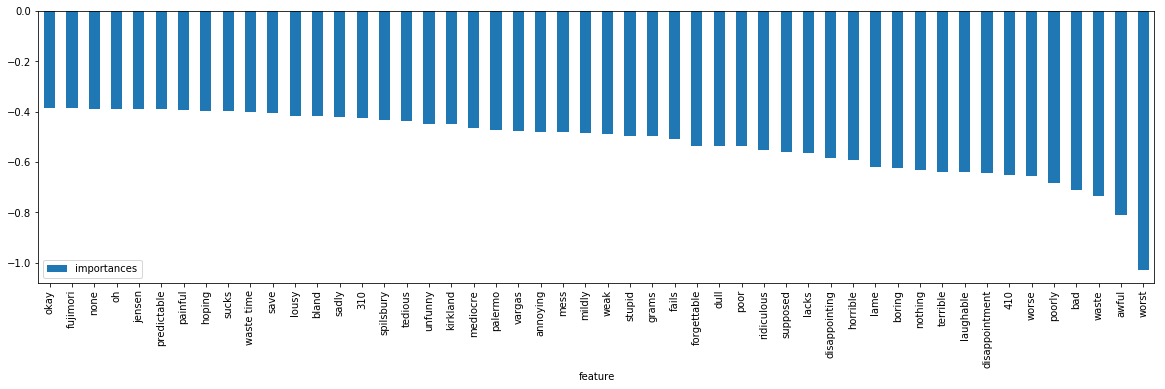

In [19]:
print('Top 50 features for Negative review:')
feature_importances.iloc[-50:, -50:].plot.bar(figsize=(20,5));